### Contents

- [Introduction](#section1)
- [Overview of Dataset](#section2)
- [Exploratory Data Analysis](#section3)
- [Data Pre-processing](#section4)
- [Train-Test Split](#section5)
- [Model Comparison](#section6)
- [Model Metrics](#section7)
- [Risk Stratification Report](#section8)
- [Classification Report](#section9)
- [Model Save](#section10)

<h2 id="section1">Introduction</h2>

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import umap.umap_ as umap
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet import ResNet152
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.callbacks import TensorBoard
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras.preprocessing import image

<h2 id="section2">CONTEXT</h2>

According to the American Kennel Club (AKC), there are nearly 200 recognized dog breeds, each with distinct characteristics and traits. Dog breed identification is a fascinating challenge with practical applications in veterinary care, pet adoption, and lost pet recovery. This dataset, sourced from Kaggle's Dog Breed Identification competition, consists of thousands of labeled images representing nearly 200 different dog breeds. By leveraging advanced image recognition techniques, this project aims to develop an AI model capable of accurately classifying dog breeds from images. The ability to swiftly and accurately identify a dog's breed can aid in understanding the pet's behavior, health predispositions, and care requirements, providing valuable insights and enhancing various animal-related services.

<h2 id="section2">Overview</h2>
This section provides an overview of the dataset.

In [7]:
# Load the labels and sample submission files
labels_df = pd.read_csv('labels.csv')

# 1. Data Dimension, Shape, Overview, Missing Data, first few rows
# Data Dimension and Shape
print(labels_df.head())

print("Data Dimension and Shape:")
print(labels_df.shape)

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever
Data Dimension and Shape:
(10222, 2)


The dataset consists of 10222 rows and 2 columns, representing the 
- **id** : The unique identifier for each image file, and
- **breed** : The breed of the dog in the image

In [9]:
# Overview
print("\nNumber of unique dog breeds:")
print(labels_df['breed'].nunique())

print("\nDataset overview:")
labels_df.info()

# Missing Data
print("\nChecking for missing data:")
print(labels_df.isnull().sum())


Number of unique dog breeds:
120

Dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB

Checking for missing data:
id       0
breed    0
dtype: int64


Both columns, `id` and `breed`, are of object type, and there are **no** missing values in this dataset.

In [11]:
# Summary statistics
print("\nSummary statistics:")
print(labels_df.describe())


Summary statistics:
                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


The most frequent breed in the dataset is the Scottish Deerhound, with 126 images. Each image has a unique ID, ensuring no duplicates. This diverse and well-distributed dataset is ideal for training a robust AI model for dog breed classification.

In [13]:
# Checking for corrupted images

# files_path = []
# for root, dirs, files in os.walk("train", topdown=False):
#   for name in sorted(files):
#      files_path.append(os.path.join(root, name))
# files = pd.DataFrame(list(zip(files_path,labels.breed.to_list())),columns=['path','label'])
# files.head()

# Set paths
train_dir = 'train'
test_dir = 'test'

missing_files = []
for filename in labels_df['id']:
    filepath = os.path.join(train_dir, filename + '.jpg')
    if not os.path.isfile(filepath):
        missing_files.append(filename)
        
print("\nMissing or corrupted files:")
print(missing_files)


Missing or corrupted files:
[]


<h2 id="section3">Exploratory Data Analysis</h2>
This section explores the dataset in detail.

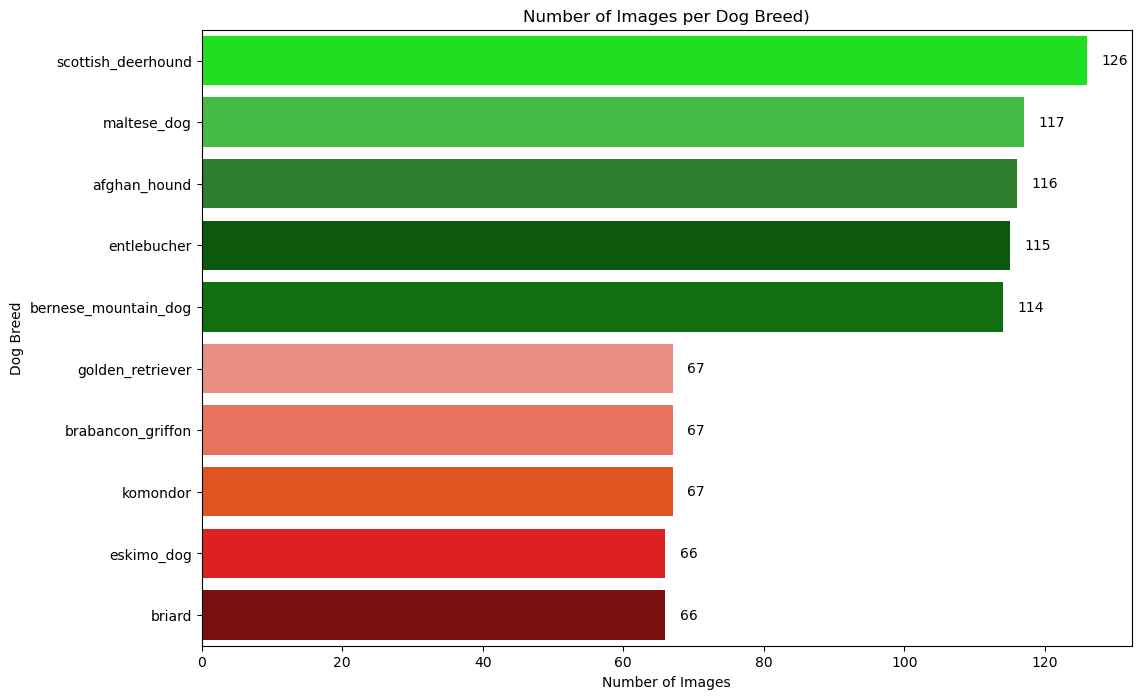

In [15]:
breed_counts = labels_df['breed'].value_counts()

# Extracting top 5 and bottom 5 breeds
top_5 = breed_counts.head(5)
bottom_5 = breed_counts.tail(5)

# Combine top 5 and bottom 5 into a single DataFrame for plotting
top_bottom_10 = pd.concat([top_5, bottom_5])

# Create a color palette with gradient green for top 5 and gradient red for bottom 5
colors = ['lime', 'limegreen', 'forestgreen', 'darkgreen', 'green']
colors += ['salmon', 'tomato', 'orangered', 'red', 'darkred']
palette = sns.color_palette(colors, n_colors=10)

# Plotting the combined bar chart with data labels
plt.figure(figsize=(12, 8))
plot = sns.barplot(y=top_bottom_10.index, x=top_bottom_10.values, palette=palette)

# Adding data labels to the bars
for i, v in enumerate(top_bottom_10.values):
    plot.text(v + 2, i, str(v), ha='left', va='center', fontsize=10, color='black')

plt.title('Number of Images per Dog Breed)')
plt.xlabel('Number of Images')
plt.ylabel('Dog Breed')
plt.show()

This bar chart illustrates the number of images available for the top 5 and bottom 5 dog breeds in the dataset. The colors indicate the ranking, with green shades representing the top 5 breeds, highest for the breed 'Scottish Deerhound' with 126 images and red shades representing the bottom 5, least for the breed 'Briard' and 'eskimo dog', with 66 images. This visual representation highlights the disparity in the number of images between the most and least represented breeds.

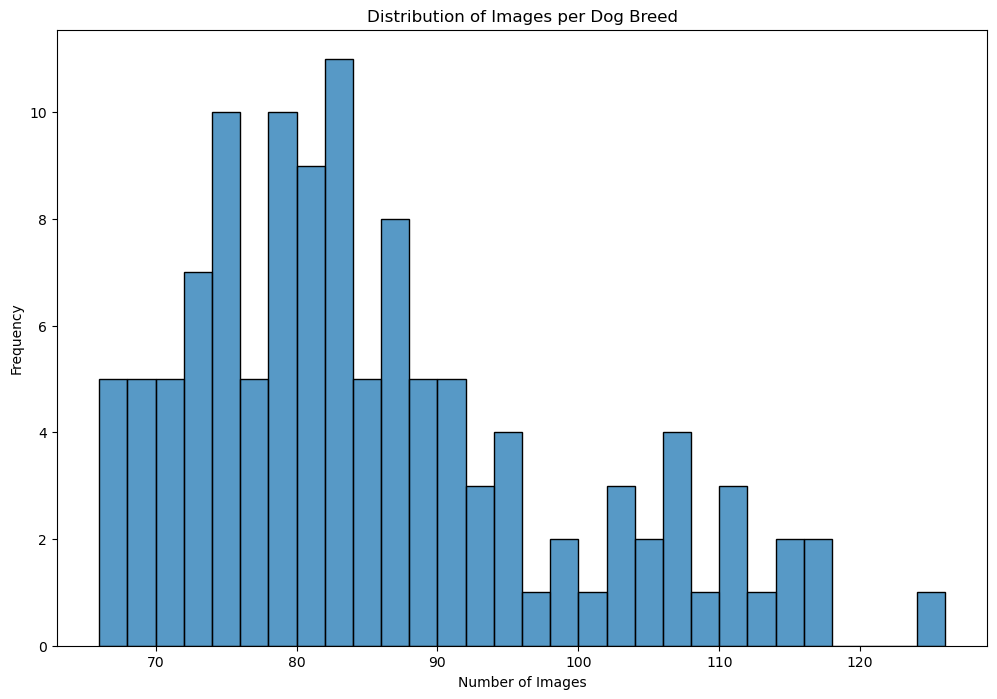

In [17]:
# 3. Distribution of Target Variable - Numerical Attributes
plt.figure(figsize=(12, 8))
sns.histplot(breed_counts, bins=30, kde=False)
plt.title('Distribution of Images per Dog Breed')
plt.xlabel('Number of Images')
plt.ylabel('Frequency')
plt.show()

The histogram shows the distribution of the number of images across all 120 dog breeds.
- The majority of breeds have between 70 to 90 images.
- A few breeds have significantly more images, with the highest count being 126.
- There is a right skew in the distribution, indicating a few breeds with substantially more images than the rest.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━

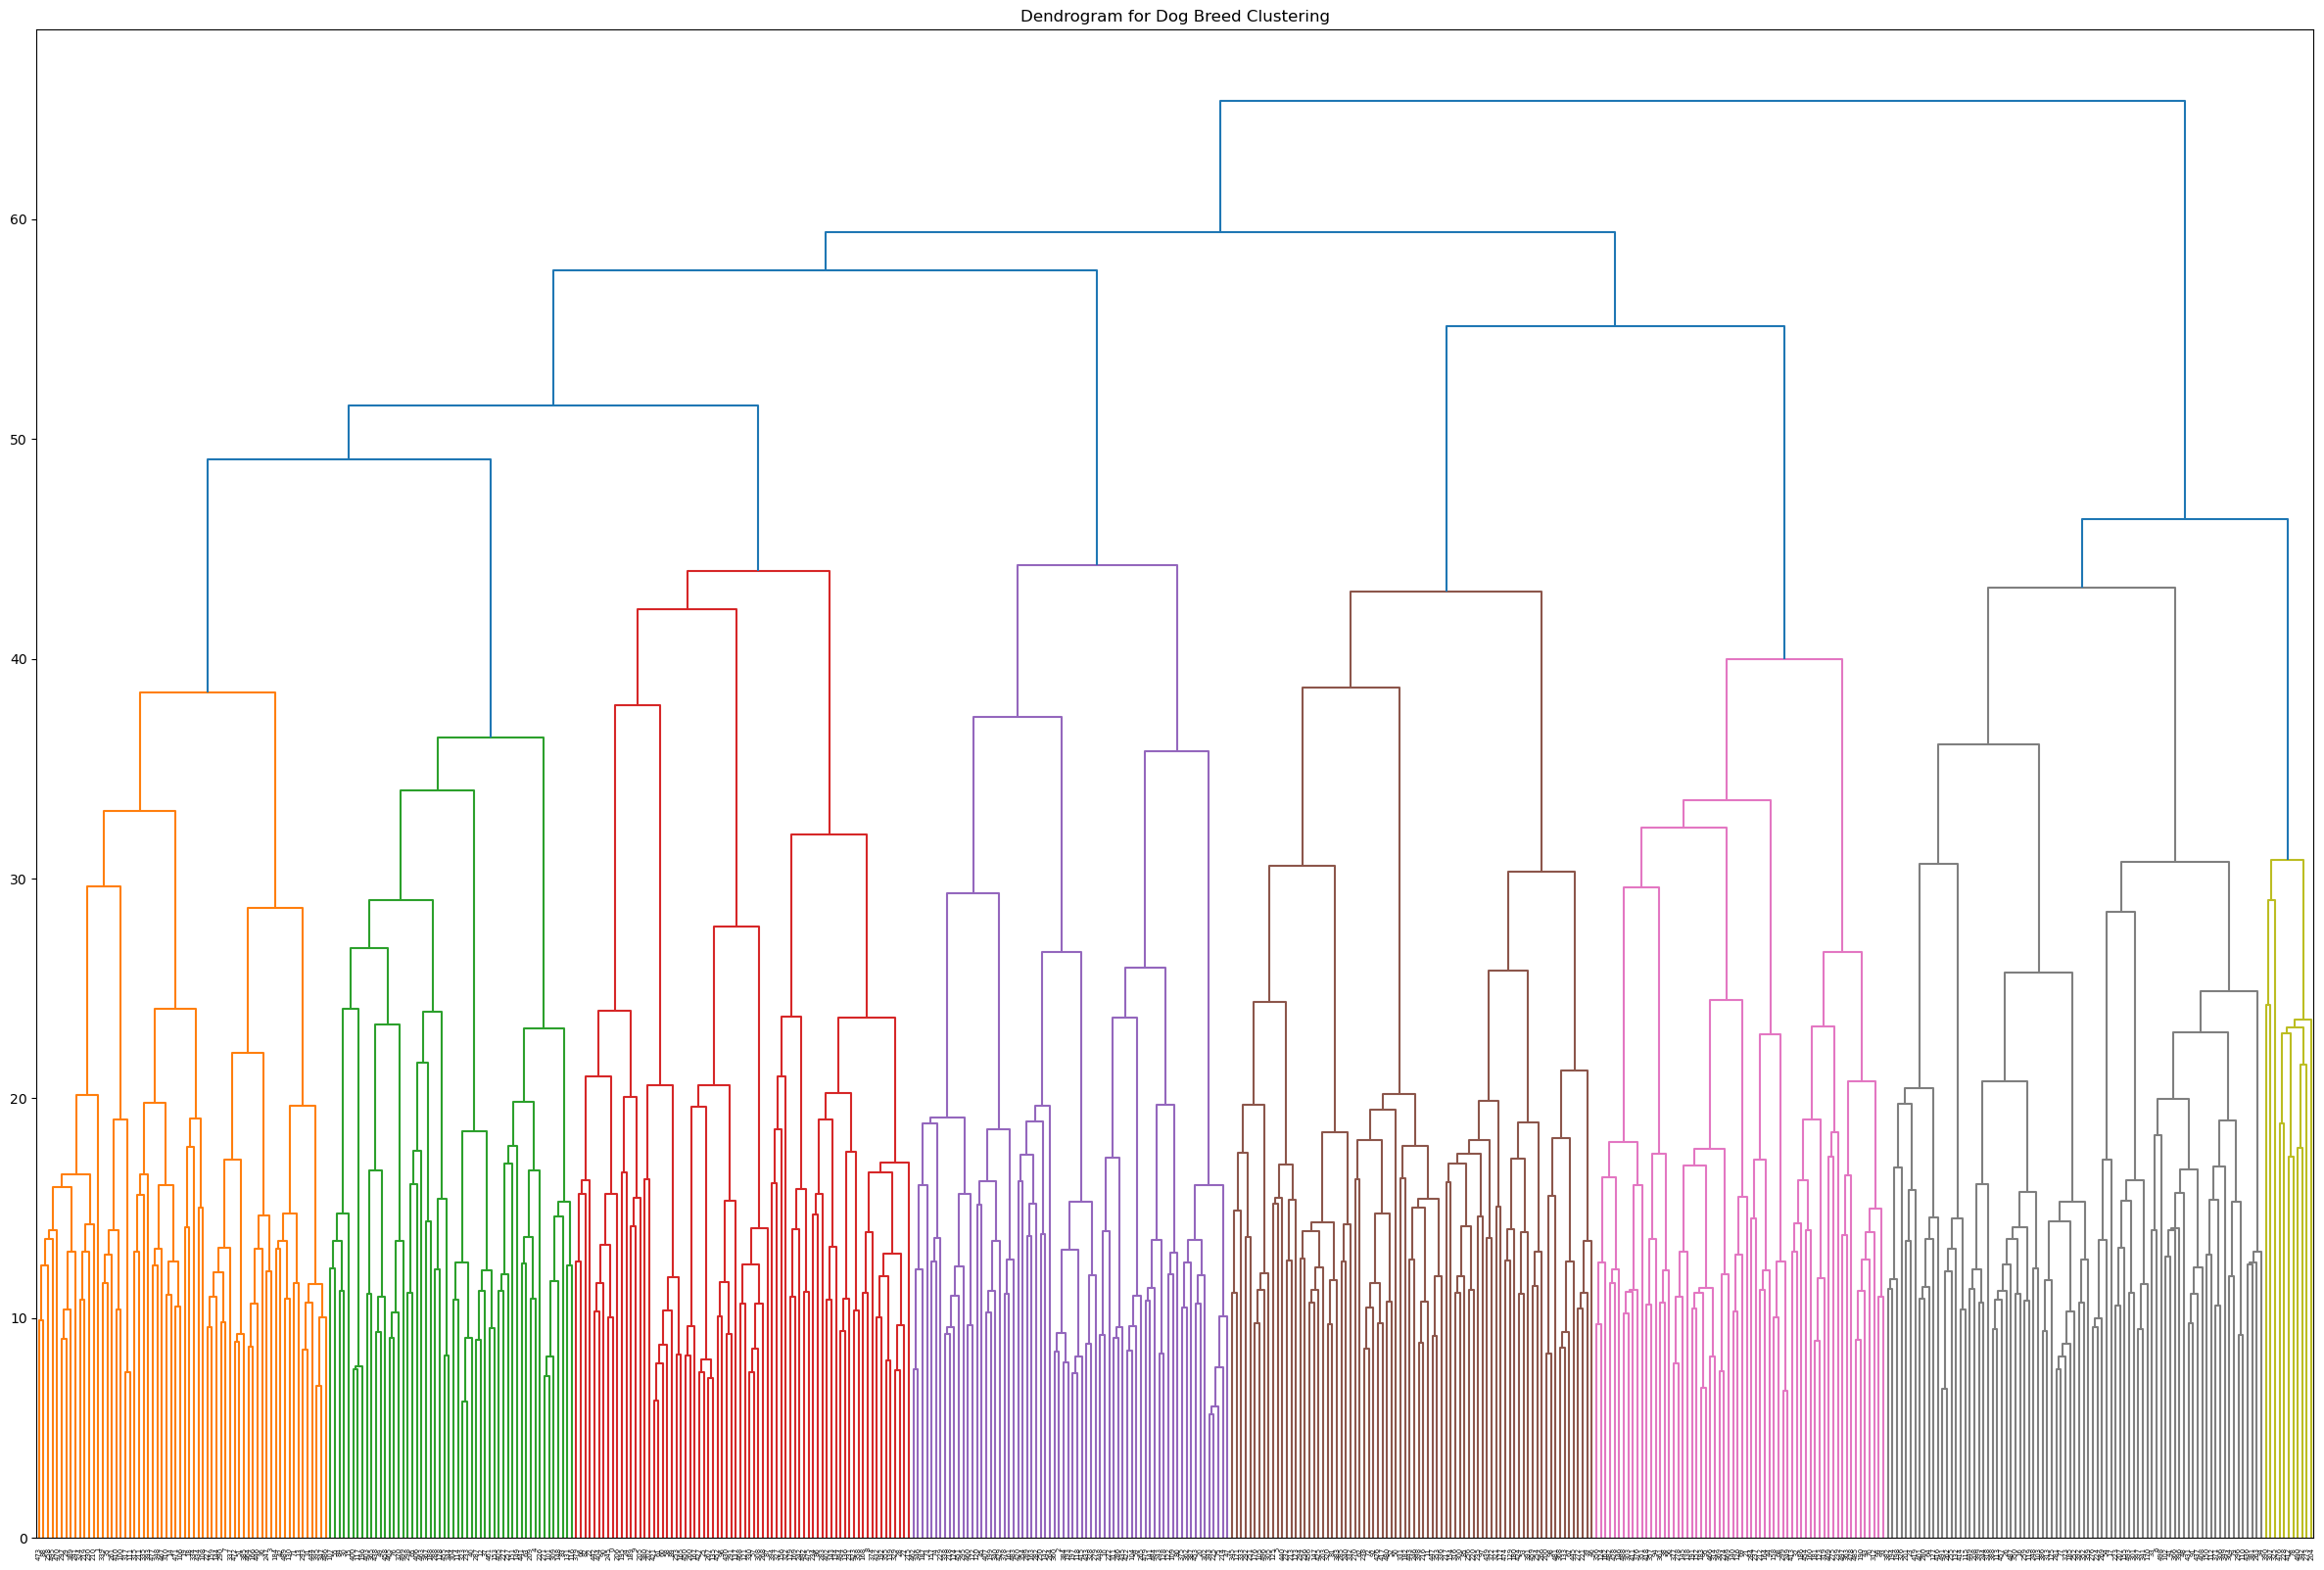

In [19]:
def extract_features(directory, labels, sample_size=500):
    model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
    features = []
    targets = []
    for idx, row in labels.sample(sample_size, random_state=42).iterrows():
        img_path = os.path.join(directory, row['id'] + '.jpg')
        img = cv2.imread(img_path)
        img = cv2.resize(img, (299, 299))
        img = np.expand_dims(img, axis=0)
        img = img / 255.0
        feature = model.predict(img)
        features.append(feature.flatten())
        targets.append(row['breed'])
    return np.array(features), np.array(targets)

features, targets = extract_features(train_dir, labels_df)

# Hierarchical clustering
linked = linkage(features, 'ward')

# Plot dendrogram
plt.figure(figsize=(30, 20))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram for Dog Breed Clustering')
plt.show()

The dendrogram graph for dog breed clustering illustrates the hierarchical relationships between different dog breeds based on their image features. At the highest level, it shows a few broad clusters, with branches indicating the level of dissimilarity between breeds. As we move down, these broad clusters break into smaller, more specific ones, revealing finer distinctions. Around the 50-60 level, large clusters form, indicating general categories of breeds. Between 20-40, these further divide into more refined groupings. The bottom levels (0-20) show individual breeds or very closely related ones. Longer branches represent more distinct differences, while shorter branches indicate closer similarities. This hierarchical structure highlights both broad and specific groupings, providing a detailed view of the relationships among dog breeds based on their image features.

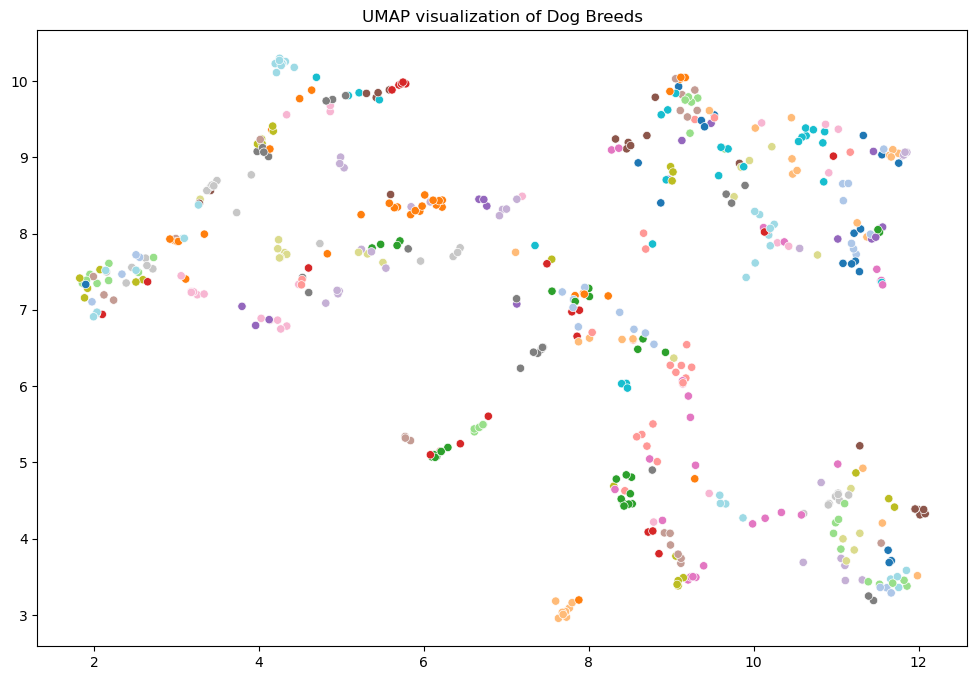

In [21]:
# Apply UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_results = reducer.fit_transform(features)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], hue=targets, palette='tab20', legend=None)
plt.title('UMAP visualization of Dog Breeds')
plt.show()

The UMAP visualization provided is an essential tool for exploratory data analysis of the 120 dog breeds in your dataset. It effectively reduces the high-dimensional image data into a two-dimensional plot, where each point represents an image, and colors indicate different breeds. In the provided UMAP visualization, clusters are well-defined, which indicates effective feature extraction for distinguishing dog breeds. The spread and separation of these clusters highlight the distinctiveness of different breeds. Points that are isolated or located away from their expected clusters can be identified as potential outliers or misclassifications. The relevance of the features used and highlighting breed similarities and differences is effectively seen.

The top 10 breeds have a relatively higher number of images compared to the bottom breeds, but the majority of the breeds have between 70 and 90 images each. This distribution suggests that while there is some imbalance, it is not extreme. Most breeds have a similar number of images, which is crucial for training a robust image recognition model, as it ensures that the model does not become biased towards a particular breed.

Overall, these plots provide a clear visual summary of the dataset, highlighting both the balance and the distribution of images across different dog breeds. This information is essential for understanding the dataset's characteristics and preparing for the subsequent steps in building and evaluating the image recognition model.

<h2 id="section4">Data Pre-processing</h2>
This section covers the steps taken for data pre-processing. Since there are no missing data, and the dataset also seems well balanced, the data seems good enough to proceed with and does not require cleaning, but the data is well augmented as below.

In [25]:
# 5. Preprocessing Data - Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Using the `ImageDataGenerator` in the code is designed to enhance the training dataset for a dog breed image classification task:

1. **Rescaling**: Normalizes the pixel values by scaling them down to a range between 0 and 1.
2. **Rotation Range**: Randomly rotates images up to 40 degrees, which helps the model generalize better by learning from different orientations.
3. **Width and Height Shifts**: Randomly shifts the images horizontally and vertically by up to 20%, allowing the model to recognize objects regardless of their position in the frame.
4. **Shear Range**: Applies random shearing transformations, which helps the model learn invariant features.
5. **Zoom Range**: Randomly zooms in on images by up to 20%, aiding in the detection of features at various scales.
6. **Horizontal Flip**: Randomly flips images horizontally, which is particularly useful for symmetry in object recognition.
7. **Fill Mode**: Uses nearest-neighbor filling to handle new pixels that may appear after transformations.

Hence, these augmentations increase the diversity of the training data, making the model more robust and improving its ability to generalize to new, unseen images.

<h2 id="section5">Train-Test Split</h2>
This section discusses the train-test split methodology.

In [28]:
# 6. Split the Data

# Encode labels
label_encoder = LabelEncoder()
labels_df['breed'] = label_encoder.fit_transform(labels_df['breed'])

# Convert labels to string type
labels_df['breed'] = labels_df['breed'].astype(str)

# Add '.jpg' extension to id column
labels_df['id'] = labels_df['id'] + '.jpg'

# Split the data
train_df, valid_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['breed'], random_state=42)
print("\nTrain and validation set sizes:")
print(train_df.shape, valid_df.shape)


Train and validation set sizes:
(8177, 2) (2045, 2)


The dataset is encoded from categorical labels (dog breeds) into numerical values to prepare the dataset for ML Algorithms which would be performed later.
These encoded numerical labels are converted back to string type after encoding. This step ensures that the labels remain interpretable and match the original format if needed.
The unique 'id' column is added with the '.jpg' extension since the filenames are stored without extensions.

Training Set (80%): Used to train the machine learning model. It contains a significant number of samples (8,177) to ensure the model learns patterns and features effectively.

Validation Set (20%): Used to evaluate the model's performance during training. With 2,045 samples, it provides a sufficient number of examples to assess how well the model generalizes to unseen data.

<h2 id="section6">Model Comparison</h2>
This section compares 3 different models used in the analysis: InceptionV3, ResNet50 and ANN model.

In [31]:
# Data generators
train_generator = datagen.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col='id',
    y_col='breed',
    target_size=(299, 299),
    batch_size=64,
    class_mode='sparse',
    num_workers=12
)

valid_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    valid_df,
    directory=train_dir,
    x_col='id',
    y_col='breed',
    target_size=(299, 299),
    batch_size=64,
    class_mode='sparse',
    num_workers=12
)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=pd.DataFrame({'id': os.listdir(test_dir)}),
    directory=test_dir,
    x_col='id',
    y_col=None,
    target_size=(299, 299),
    batch_size=64,
    class_mode=None,
    shuffle=False,
    num_workers=12
)

Found 8177 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.
Found 10357 validated image filenames.


1. **Data Generators Setup**:
   - **train_generator**: Generates batches of training data from `train_df`. Images are loaded from `train_dir`, resized to (299, 299) pixels, and processed in batches of 64. Labels (`breed`) are provided in sparse format. Found 8,177 validated image filenames belonging to 120 classes. This indicates there are 8,177 images in the training set distributed among 120 different dog breeds.
   
   - **valid_generator**: Similar to `train_generator`, but for validation data (`valid_df`). Images are also loaded from `train_dir`, resized, and processed in batches of 64 with sparse labels. Found 2,045 validated image filenames belonging to 120 classes. This suggests there are 2,045 images in the validation set, also distributed among the same 120 dog breeds.
   
   - **test_generator**: Generates batches of test data from `test_dir`. Images are loaded from `test_dir`, resized, and processed in batches of 64. No labels (`y_col=None`) are provided since this is used for prediction purposes. Found 10,357 validated image filenames. This confirms there are 10,357 images in the test set.

The generators report 120 classes, indicating the dataset encompasses 120 distinct dog breeds. This consistency across all generators (`train`, `valid`, `test`) ensures alignment in data preparation and model evaluation stages.

2. **Image Rescaling**: 
   - `ImageDataGenerator(rescale=1./255)` is used to scale pixel values to the range [0, 1] for all generators (`valid_generator`, `test_generator`). This again, standardizes input data. This ensures that all sets (`train`, `valid`, `test`) are appropriately formatted and ready for feeding into an image recognition model.

In [33]:
# Function to create CNN model
def create_cnn_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(120, activation='softmax')(x)  # 120 dog breeds
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

The `create_cnn_model` function is a robust tool designed to construct convolutional neural network (CNN) models tailored for dog breed recognition. It takes a `base_model` as input and extends it with additional layers for classification. These layers include global average pooling to reduce spatial dimensions, a dense layer with 1024 neurons for feature extraction, and a final dense layer with softmax activation to output probabilities across 120 dog breeds. This function's modularity allows it to be seamlessly used with different base models, ensuring efficient transfer learning and adaptability across various CNN architectures. Its design promotes consistency in model construction and facilitates experimentation while maintaining performance integrity in dog breed classification tasks.

In [35]:
# InceptionV3 Model
inception_base = InceptionV3(weights='imagenet', include_top=False)
inception_model = create_cnn_model(inception_base)
inception_model.compile(optimizer=Adam(learning_rate=0.0001), 
                        loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the InceptionV3 model
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpoint = ModelCheckpoint('best_inception_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
print("Training InceptionV3 model...")
inception_history = inception_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=100,
    callbacks=[early_stop, checkpoint]
)

Training InceptionV3 model...
Epoch 1/100



KeyboardInterrupt



In [ ]:
# ResNet50 Model
resnet_base = ResNet50(weights='imagenet', include_top=False)
resnet_model = create_cnn_model(resnet_base)
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), 
                     loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the ResNet50 model
checkpoint_resnet = ModelCheckpoint('best_resnet_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
print("Training ResNet50 model...")
resnet_history = resnet_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=100,
    callbacks=[early_stop, checkpoint_resnet]
)

In [ ]:
# ANN Model
ann_model = Sequential([
    Flatten(input_shape=(299, 299, 3)),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(120, activation='softmax')
])
ann_model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the ANN model
checkpoint_ann = ModelCheckpoint('best_ann_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
print("Training ANN model...")
ann_history = ann_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=100,
    callbacks=[early_stop, checkpoint_ann]
)

In [ ]:
# Model evaluation and visualization
def plot_metrics(history, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.show()

# Plot metrics for each model
plot_metrics(inception_history, 'InceptionV3 Model Accuracy')
plot_metrics(resnet_history, 'ResNet50 Model Accuracy')
plot_metrics(ann_history, 'ANN Model Accuracy')
